### Necessary Packages

In [1]:
import torch
import sys
import dotenv
import os
import torch
import seaborn as sns
import matplotlib.pyplot as plt
sys.path.append('../../..')
from src.models import HIPT_WSI
from torch.utils.data import DataLoader
from torchvision.transforms import Lambda
from src.utils import load_model_from_folder,load_history_from_folder
from src.datasets import TensorDataset
from tqdm.notebook import tqdm
from torchmetrics import F1Score,Accuracy,AUROC,Metric

Key OPENSLIDE_PATH not found in /home/abdelnour/Documents/4eme_anne/S2/project_2sc/repo/.env.
Key OPENSLIDE_PATH not found in /home/abdelnour/Documents/4eme_anne/S2/project_2sc/repo/.env.


### Setup the code to be device agnostic

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device.type)

cuda


### Results reproducibility

In [3]:
torch.manual_seed(0)

### Loading envirement variables

In [4]:
TENSORS_DIR = "/home/abdelnour/Documents/4eme_anne/S2/project_2sc/repo/data/tensors"
MODELS_DIR = dotenv.get_key(dotenv.find_dotenv(), "MODELS_DIR")
HISTORIES_DIR = dotenv.get_key(dotenv.find_dotenv(), "HISTORIES_DIR")

In [5]:
TRAIN_DIR = os.path.join(TENSORS_DIR, "train")
VAL_DIR = os.path.join(TENSORS_DIR, "val")
TEST_DIR = os.path.join(TENSORS_DIR, "test")

In [6]:
print(MODELS_DIR)
print(TENSORS_DIR)
print(HISTORIES_DIR)
print(TRAIN_DIR)
print(VAL_DIR)
print(TEST_DIR)

/home/abdelnour/Documents/4eme_anne/S2/project_2sc/repo/models
/home/abdelnour/Documents/4eme_anne/S2/project_2sc/repo/data/tensors
/home/abdelnour/Documents/4eme_anne/S2/project_2sc/repo/histories
/home/abdelnour/Documents/4eme_anne/S2/project_2sc/repo/data/tensors/train
/home/abdelnour/Documents/4eme_anne/S2/project_2sc/repo/data/tensors/val
/home/abdelnour/Documents/4eme_anne/S2/project_2sc/repo/data/tensors/test


### Global

In [7]:
BATCH_SIZE = 1
NUM_WORKERS = 0
PREFETCH_FACTOR = None
WEIGHTS_FOLDER  = os.path.join(MODELS_DIR, "HIPT_WSI")
HISTORIES_FOLDER = path = os.path.join(HISTORIES_DIR, "HIPT_WSI")

### Load the model

In [8]:
model = HIPT_WSI(
    dropout=0.2
).to(device)

/home/abdelnour/anaconda3/envs/project/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [9]:
load_model_from_folder(model, WEIGHTS_FOLDER, verbose=True)

loading weights with name : 1716451068.2546368.pt


### Learning graph

In [10]:
history_df = load_history_from_folder(HISTORIES_FOLDER)

<Axes: xlabel='epoch', ylabel='accuracy'>

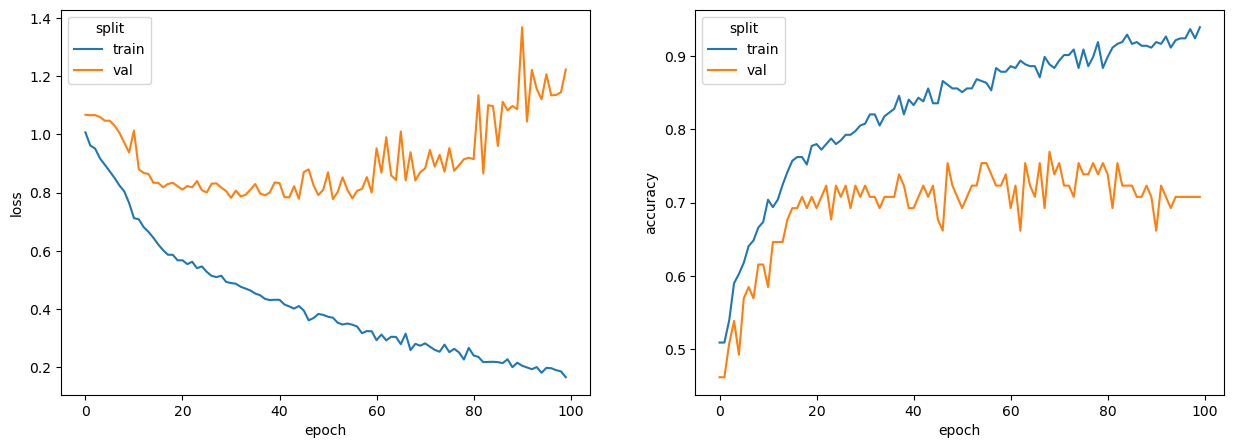

In [11]:
fig, (ax1, ax2) = plt.subplots(ncols=2)

fig.set_size_inches(15, 5)

sns.lineplot(data=history_df, x="epoch", y="loss", hue="split", ax=ax1)
sns.lineplot(data=history_df, x="epoch", y="accuracy", hue="split", ax=ax2)

### Data Loading

In [12]:
transfrom = Lambda(lambd=lambda x : torch.permute(x, dims=(1,2,0)).reshape(-1, x.shape[0]))
datatset = TensorDataset(root=TEST_DIR,transform=transfrom)
loader = DataLoader(dataset=datatset, batch_size=1, shuffle=True)

### Inference

In [13]:
def predict(
    loader : DataLoader,
    model : HIPT_WSI
) -> tuple[torch.Tensor,torch.Tensor]:
    
    model.eval()

    Y_hat = []
    Y = []

    with torch.inference_mode():

        for x,y in tqdm(loader):

            x,y = x.to(device),y.to(device)

            y_hat = model(x)
            y_hat = torch.squeeze(y_hat)

            y = torch.squeeze(y).item()

            Y.append(y)
            Y_hat.append(y_hat)
    
    Y_hat = torch.vstack(Y_hat)
    Y = torch.tensor(Y)
    Y = Y.squeeze()
    Y = Y.to(device)

    return Y_hat,Y

In [14]:
Y_hat,Y = predict(loader,model)

  0%|          | 0/87 [00:00<?, ?it/s]

In [15]:
print(Y_hat.shape,Y.shape)

torch.Size([87, 3]) torch.Size([87])


### Computing metrics

In [16]:
metrics = {
    "accuracy" : Accuracy(task='multiclass',num_classes=3).to(device),
    "f1_score" : F1Score(task='multiclass',num_classes=3,average='macro').to(device),
    "auc" : AUROC(task='multiclass',num_classes=3).to(device)
}

In [17]:
def compute_metrics(metrics : dict[str,Metric], y : torch.Tensor, y_hat : torch.Tensor) -> dict:

    result = {}

    for name, metric in metrics.items():
        score = metric(y_hat, y)
        result[name] = score.item()

    return  result

In [18]:
compute_metrics(metrics, Y, Y_hat)

{'accuracy': 0.6206896305084229,
 'f1_score': 0.5686479806900024,
 'auc': 0.7739995718002319}